# Function Encoders: Learning Representations of Function Spaces

**Learning Objectives:**
- Understand the concept of function space representations
- Learn how function encoders create data-driven basis functions
- Master the encoder-decoder architecture for function spaces
- Compare learned bases with classical approaches (Fourier, polynomial)
- Build foundation for operator learning applications

---

## Motivation: From Points to Functions

Traditional neural networks map points to points: $\mathbb{R}^n \rightarrow \mathbb{R}^m$

But many problems require working with **entire functions**:
- PDEs operate on function spaces
- Operators map functions to functions
- Physical fields are continuous functions

**Key question:** How do we represent infinite-dimensional functions with finite-dimensional neural networks?

**Answer:** Learn optimal basis representations!

## Theory: Function Encoders in Hilbert Spaces

### Mathematical Framework

Function encoders learn data-driven basis representations of function spaces. Given a function $f \in \mathcal{H}$ where $\mathcal{H}$ is a Hilbert space, we seek a representation:

$$f(x) = \sum_{j=1}^d \alpha_j g_j(x)$$

where $\{g_j\}_{j=1}^d$ forms a basis for a $d$-dimensional subspace of $\mathcal{H}$.

### Coefficient Computation Methods

Three approaches for computing coefficients $\alpha_j$:

1. **Inner Product** (exact for orthonormal bases):
   $$\alpha_j = \langle f, g_j \rangle = \int_\Omega f(x) g_j(x) dx$$

2. **Monte Carlo Integration**:
   $$\alpha_j \approx \frac{V}{|D|} \sum_{x \in D} f(x) g_j(x)$$
   where $V$ is the domain volume and $D$ is a set of sample points.

3. **Least Squares**:
   $$\min_{\alpha} \frac{1}{m} \sum_{i=1}^m \left\| f(x_i) - \sum_{j=1}^d \alpha_j g_j(x_i) \right\|^2$$
   
   Solution: $\alpha = (G^T G)^{-1} G^T f$ where $G_{ij} = g_j(x_i)$.

### Orthonormality and Regularization

The quality of the basis can be assessed via the Gram matrix:
$$\mathcal{G}_{ij} = \langle g_i, g_j \rangle$$

For an orthonormal basis, $\mathcal{G} = I$. L1 regularization can promote sparsity in the coefficient representation:
$$\mathcal{L} = \|f - \sum_j \alpha_j g_j\|^2 + \lambda \|\alpha\|_1$$

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else 
                     "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


## Part 1: Classical Basis Representations

### Traditional Approach: Fixed Basis Functions

Any function can be represented as a linear combination of basis functions:
$$f(x) = \sum_{i=1}^n c_i \phi_i(x)$$

Classical choices:
- **Fourier basis:** $\{\sin(n\pi x), \cos(n\pi x)\}$ - optimal for periodic functions
- **Polynomial basis:** $\{1, x, x^2, x^3, ...\}$ - Taylor series expansion
- **Wavelet basis:** Multi-scale, localized functions

**Limitation:** These bases are fixed and may not be optimal for specific function classes!

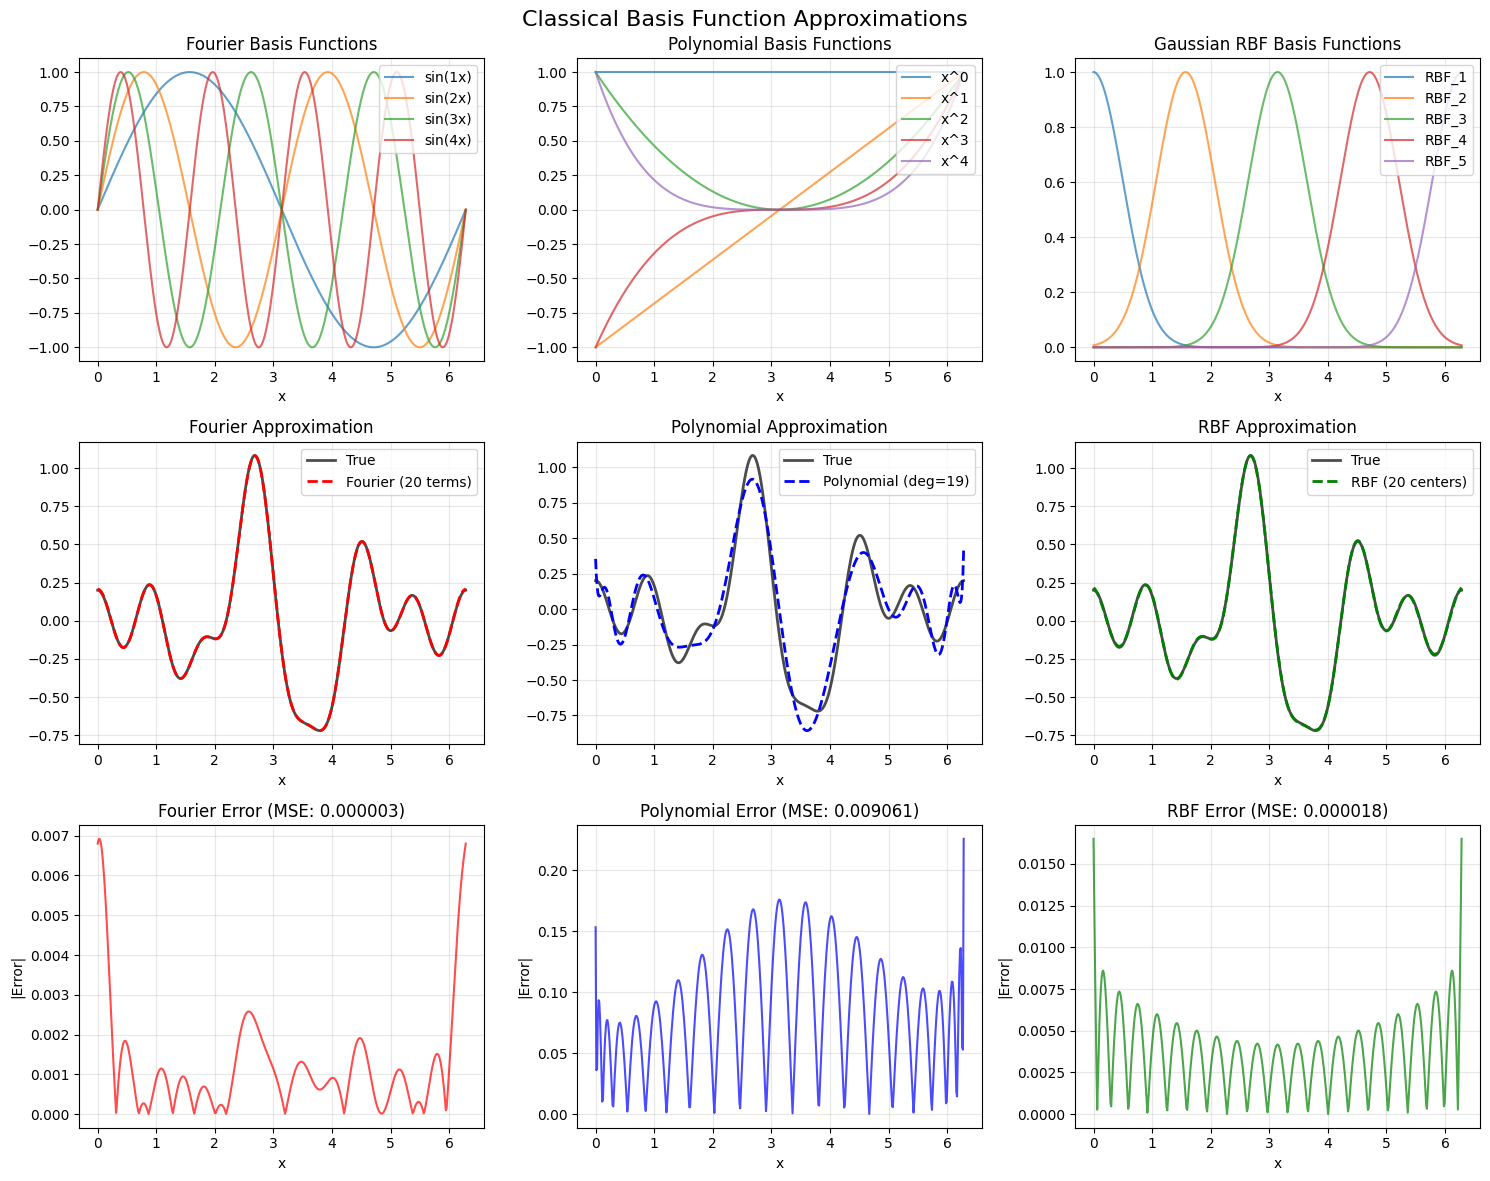

Approximation Errors (MSE):
• Fourier: 0.000003
• Polynomial: 0.009061
• RBF: 0.000018

Key Insight: Different bases are optimal for different function types!
What if we could learn the optimal basis for our specific problem?


In [2]:
def compare_classical_bases():
    """Compare different classical basis representations"""
    
    x = np.linspace(0, 2*np.pi, 500)
    
    # Target function: combination of smooth and oscillatory
    def target_function(x):
        return np.exp(-0.5*(x-np.pi)**2) * np.sin(3*x) + 0.2*np.cos(7*x)
    
    y_true = target_function(x)
    
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    
    # Row 1: Basis functions
    # Fourier basis
    ax = axes[0, 0]
    for n in range(1, 5):
        ax.plot(x, np.sin(n*x), alpha=0.7, label=f'sin({n}x)')
    ax.set_title('Fourier Basis Functions')
    ax.set_xlabel('x')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    # Polynomial basis
    ax = axes[0, 1]
    x_norm = (x - np.pi) / np.pi  # Normalize for stability
    for n in range(5):
        ax.plot(x, x_norm**n, alpha=0.7, label=f'x^{n}')
    ax.set_title('Polynomial Basis Functions')
    ax.set_xlabel('x')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    # Gaussian RBF basis
    ax = axes[0, 2]
    centers = np.linspace(0, 2*np.pi, 5)
    for i, c in enumerate(centers):
        ax.plot(x, np.exp(-2*(x-c)**2), alpha=0.7, label=f'RBF_{i+1}')
    ax.set_title('Gaussian RBF Basis Functions')
    ax.set_xlabel('x')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    # Row 2: Approximations
    n_basis = 20
    
    # Fourier approximation
    ax = axes[1, 0]
    y_fourier = np.zeros_like(x)
    for n in range(1, n_basis//2):
        an = 2/len(x) * np.sum(y_true * np.sin(n*x))
        bn = 2/len(x) * np.sum(y_true * np.cos(n*x))
        y_fourier += an * np.sin(n*x) + bn * np.cos(n*x)
    
    ax.plot(x, y_true, 'k-', linewidth=2, label='True', alpha=0.7)
    ax.plot(x, y_fourier, 'r--', linewidth=2, label=f'Fourier ({n_basis} terms)')
    ax.set_title('Fourier Approximation')
    ax.set_xlabel('x')
    ax.legend()
    ax.grid(True, alpha=0.3)
    fourier_error = np.mean((y_true - y_fourier)**2)
    
    # Polynomial approximation
    ax = axes[1, 1]
    coeffs = np.polyfit(x, y_true, n_basis-1)
    y_poly = np.polyval(coeffs, x)
    
    ax.plot(x, y_true, 'k-', linewidth=2, label='True', alpha=0.7)
    ax.plot(x, y_poly, 'b--', linewidth=2, label=f'Polynomial (deg={n_basis-1})')
    ax.set_title('Polynomial Approximation')
    ax.set_xlabel('x')
    ax.legend()
    ax.grid(True, alpha=0.3)
    poly_error = np.mean((y_true - y_poly)**2)
    
    # RBF approximation
    ax = axes[1, 2]
    centers = np.linspace(0, 2*np.pi, n_basis)
    rbf_matrix = np.exp(-2 * (x[:, None] - centers[None, :])**2)
    coeffs_rbf = np.linalg.lstsq(rbf_matrix, y_true, rcond=None)[0]
    y_rbf = rbf_matrix @ coeffs_rbf
    
    ax.plot(x, y_true, 'k-', linewidth=2, label='True', alpha=0.7)
    ax.plot(x, y_rbf, 'g--', linewidth=2, label=f'RBF ({n_basis} centers)')
    ax.set_title('RBF Approximation')
    ax.set_xlabel('x')
    ax.legend()
    ax.grid(True, alpha=0.3)
    rbf_error = np.mean((y_true - y_rbf)**2)
    
    # Row 3: Error analysis
    ax = axes[2, 0]
    ax.plot(x, np.abs(y_true - y_fourier), 'r-', alpha=0.7)
    ax.set_title(f'Fourier Error (MSE: {fourier_error:.6f})')
    ax.set_xlabel('x')
    ax.set_ylabel('|Error|')
    ax.grid(True, alpha=0.3)
    
    ax = axes[2, 1]
    ax.plot(x, np.abs(y_true - y_poly), 'b-', alpha=0.7)
    ax.set_title(f'Polynomial Error (MSE: {poly_error:.6f})')
    ax.set_xlabel('x')
    ax.set_ylabel('|Error|')
    ax.grid(True, alpha=0.3)
    
    ax = axes[2, 2]
    ax.plot(x, np.abs(y_true - y_rbf), 'g-', alpha=0.7)
    ax.set_title(f'RBF Error (MSE: {rbf_error:.6f})')
    ax.set_xlabel('x')
    ax.set_ylabel('|Error|')
    ax.grid(True, alpha=0.3)
    
    plt.suptitle('Classical Basis Function Approximations', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Summary
    print("Approximation Errors (MSE):")
    print(f"• Fourier: {fourier_error:.6f}")
    print(f"• Polynomial: {poly_error:.6f}")
    print(f"• RBF: {rbf_error:.6f}")
    print("\nKey Insight: Different bases are optimal for different function types!")
    print("What if we could learn the optimal basis for our specific problem?")

compare_classical_bases()

## Part 2: The Function Encoder Architecture

### Core Concept: Learn the Basis

Instead of using fixed basis functions, **learn them from data**!

**Function Encoder Components:**

1. **Encoder Network:** $E: \mathbb{R}^m \rightarrow \mathbb{R}^n$
   - Input: Function values at sensor points $[f(x_1), ..., f(x_m)]$
   - Output: Coefficients $[c_1, ..., c_n]$

2. **Decoder Network:** $D: \mathbb{R} \rightarrow \mathbb{R}^n$
   - Input: Query point $x$
   - Output: Basis function values $[\phi_1(x), ..., \phi_n(x)]$

3. **Reconstruction:** $\hat{f}(x) = \sum_{i=1}^n c_i \phi_i(x) = \langle c, \phi(x) \rangle$

**Training Objective:** Minimize reconstruction error
$$\mathcal{L} = \mathbb{E}_{f \sim \mathcal{F}} \left[ \|f - \hat{f}\|^2 \right]$$

In [3]:
class FunctionEncoder(nn.Module):
    """Neural network that learns to encode functions into finite representations"""
    
    def __init__(self, sensor_dim, n_basis, hidden_dim=64, activation='tanh'):
        super().__init__()
        self.sensor_dim = sensor_dim
        self.n_basis = n_basis
        self.hidden_dim = hidden_dim
        
        # Select activation
        self.activation = nn.Tanh() if activation == 'tanh' else nn.ReLU()
        
        # Encoder: processes function samples to extract coefficients
        self.encoder = nn.Sequential(
            nn.Linear(sensor_dim, hidden_dim),
            self.activation,
            nn.Linear(hidden_dim, hidden_dim),
            self.activation,
            nn.Linear(hidden_dim, n_basis)
        )
        
        # Decoder: generates basis functions at query points
        self.decoder = nn.Sequential(
            nn.Linear(1, hidden_dim),
            self.activation,
            nn.Linear(hidden_dim, hidden_dim),
            self.activation,
            nn.Linear(hidden_dim, n_basis)
        )
        
    def encode(self, function_samples):
        """Extract coefficients from function samples
        Args:
            function_samples: [batch_size, sensor_dim]
        Returns:
            coefficients: [batch_size, n_basis]
        """
        return self.encoder(function_samples)
    
    def decode_basis(self, x):
        """Generate basis function values at query points
        Args:
            x: [n_points, 1] or [batch_size, n_points, 1]
        Returns:
            basis_values: [..., n_points, n_basis]
        """
        return self.decoder(x)
    
    def reconstruct(self, coefficients, x):
        """Reconstruct function from coefficients
        Args:
            coefficients: [batch_size, n_basis]
            x: [batch_size, n_points, 1]
        Returns:
            f_reconstructed: [batch_size, n_points]
        """
        batch_size, n_points, _ = x.shape
        
        # Get basis functions
        basis_values = self.decoder(x.reshape(-1, 1))  # [batch*n_points, n_basis]
        basis_values = basis_values.view(batch_size, n_points, self.n_basis)
        
        # Linear combination
        f_reconstructed = torch.einsum('bn,bpn->bp', coefficients, basis_values)
        return f_reconstructed
    
    def forward(self, function_samples, query_points):
        """Full forward pass: encode then reconstruct"""
        coefficients = self.encode(function_samples)
        return self.reconstruct(coefficients, query_points)


print("Function Encoder Architecture Created")
print("Components:")
print("• Encoder: Maps function samples → coefficient representation")
print("• Decoder: Maps query points → basis function values")
print("• Reconstruction: Linear combination of learned basis functions")

Function Encoder Architecture Created
Components:
• Encoder: Maps function samples → coefficient representation
• Decoder: Maps query points → basis function values
• Reconstruction: Linear combination of learned basis functions


## Part 3: Learning Function Spaces - A Simple Example

Let's learn to represent a family of Gaussian mixture functions:
$$f(x) = \sum_{k=1}^K a_k \exp\left(-\frac{(x - \mu_k)^2}{2\sigma_k^2}\right)$$

This is a good test case because:
- The function family has clear structure
- Neither polynomials nor Fourier bases are optimal
- We can visualize what the encoder learns

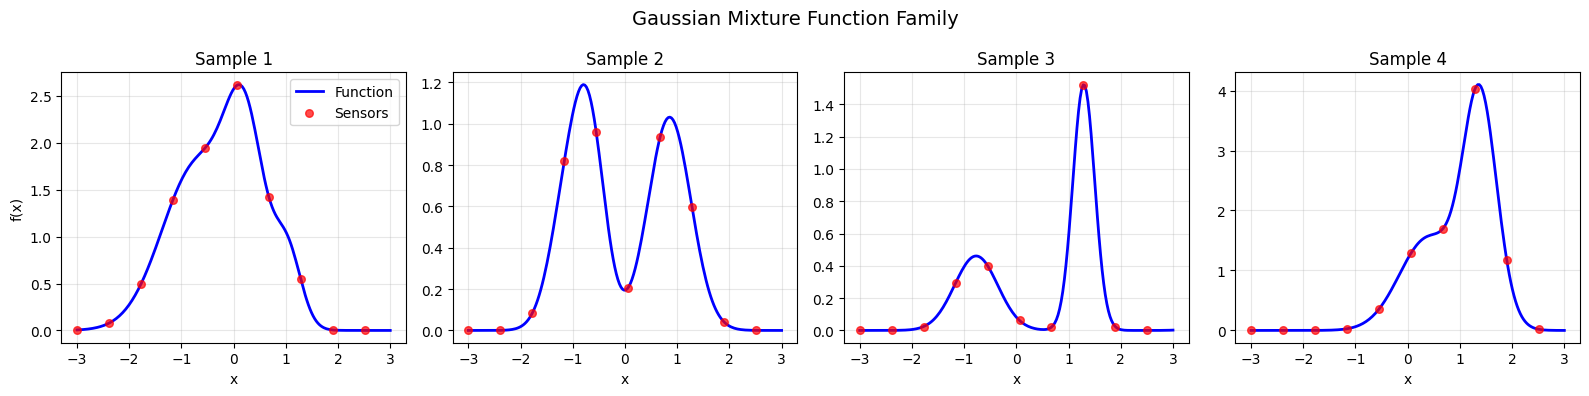

Dataset created: 1600 training, 400 test samples
Each function: 50 sensors, 200 query points


In [4]:
class GaussianMixtureDataset(Dataset):
    """Dataset of Gaussian mixture functions"""
    
    def __init__(self, n_samples=1000, n_sensors=50, n_query=200, 
                 x_range=(-3, 3), n_components=3):
        self.n_samples = n_samples
        self.n_sensors = n_sensors
        self.n_query = n_query
        self.n_components = n_components
        
        # Fixed sensor and query locations
        self.sensor_x = torch.linspace(x_range[0], x_range[1], n_sensors)
        self.query_x = torch.linspace(x_range[0], x_range[1], n_query)
        
        # Generate random Gaussian parameters
        self.amplitudes = torch.rand(n_samples, n_components) * 2
        self.centers = torch.randn(n_samples, n_components) * 1.5
        self.widths = torch.rand(n_samples, n_components) * 0.5 + 0.2
    
    def evaluate_gaussian_mixture(self, idx, x):
        """Evaluate Gaussian mixture at points x"""
        f = torch.zeros_like(x)
        for k in range(self.n_components):
            f += self.amplitudes[idx, k] * torch.exp(
                -(x - self.centers[idx, k])**2 / (2 * self.widths[idx, k]**2)
            )
        return f
    
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        # Function values at sensor points
        sensor_y = self.evaluate_gaussian_mixture(idx, self.sensor_x)
        
        # Function values at query points
        query_y = self.evaluate_gaussian_mixture(idx, self.query_x)
        
        return {
            'sensor_y': sensor_y,
            'query_x': self.query_x.unsqueeze(-1),
            'query_y': query_y
        }


# Create dataset
dataset = GaussianMixtureDataset(n_samples=2000, n_sensors=50, n_query=200)
train_size = int(0.8 * len(dataset))
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, len(dataset) - train_size]
)

# Visualize samples
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, ax in enumerate(axes):
    sample = dataset[i*100]
    x = dataset.query_x.numpy()
    y = sample['query_y'].numpy()
    
    ax.plot(x, y, 'b-', linewidth=2)
    ax.scatter(dataset.sensor_x[::5], sample['sensor_y'][::5], 
               c='red', s=30, alpha=0.7, zorder=5)
    ax.set_title(f'Sample {i+1}')
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('x')
    if i == 0:
        ax.set_ylabel('f(x)')
        ax.legend(['Function', 'Sensors'], loc='upper right')

plt.suptitle('Gaussian Mixture Function Family', fontsize=14)
plt.tight_layout()
plt.show()

print(f"Dataset created: {train_size} training, {len(test_dataset)} test samples")
print(f"Each function: {dataset.n_sensors} sensors, {dataset.n_query} query points")

## Part 4: Training the Function Encoder


Training with 5 basis functions...


Training: 100%|██████████| 150/150 [00:35<00:00,  4.19it/s]


Final test loss: 0.047959

Training with 10 basis functions...


Training: 100%|██████████| 150/150 [00:35<00:00,  4.20it/s]


Final test loss: 0.006645

Training with 20 basis functions...


Training: 100%|██████████| 150/150 [00:35<00:00,  4.26it/s]


Final test loss: 0.005642


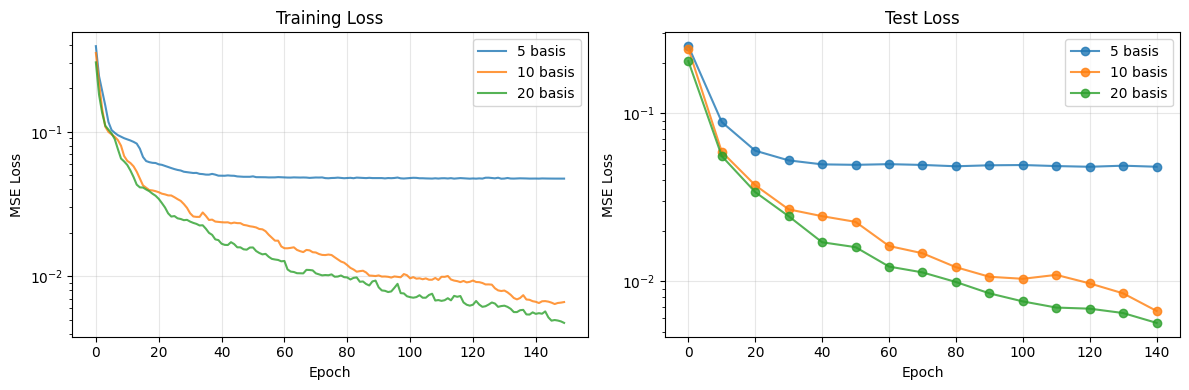

In [5]:
def train_function_encoder(model, train_dataset, test_dataset, 
                          n_epochs=200, batch_size=32, lr=1e-3):
    """Train the function encoder to reconstruct functions"""
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    
    train_losses = []
    test_losses = []
    
    for epoch in tqdm(range(n_epochs), desc="Training"):
        # Training
        model.train()
        train_loss = 0
        for batch in train_loader:
            sensor_y = batch['sensor_y'].to(device)
            query_x = batch['query_x'].to(device)
            query_y = batch['query_y'].to(device)
            
            # Forward pass
            pred_y = model(sensor_y, query_x)
            loss = F.mse_loss(pred_y, query_y)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_losses.append(train_loss / len(train_loader))
        
        # Testing
        if epoch % 10 == 0:
            model.eval()
            test_loss = 0
            with torch.no_grad():
                for batch in test_loader:
                    sensor_y = batch['sensor_y'].to(device)
                    query_x = batch['query_x'].to(device)
                    query_y = batch['query_y'].to(device)
                    
                    pred_y = model(sensor_y, query_x)
                    loss = F.mse_loss(pred_y, query_y)
                    test_loss += loss.item()
            
            test_losses.append(test_loss / len(test_loader))
            scheduler.step(test_loss / len(test_loader))
    
    return train_losses, test_losses


# Train multiple models with different basis sizes
basis_sizes = [5, 10, 20]
models = {}
losses = {}

for n_basis in basis_sizes:
    print(f"\nTraining with {n_basis} basis functions...")
    model = FunctionEncoder(sensor_dim=50, n_basis=n_basis, hidden_dim=64).to(device)
    train_losses, test_losses = train_function_encoder(
        model, train_dataset, test_dataset, n_epochs=150, batch_size=64
    )
    models[n_basis] = model
    losses[n_basis] = (train_losses, test_losses)
    print(f"Final test loss: {test_losses[-1]:.6f}")

# Plot training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
for n_basis in basis_sizes:
    plt.plot(losses[n_basis][0], label=f'{n_basis} basis', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
for n_basis in basis_sizes:
    epochs = np.arange(0, 150, 10)
    plt.plot(epochs, losses[n_basis][1], 'o-', label=f'{n_basis} basis', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Test Loss')
plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Part 5: Analyzing the Learned Representations


Analyzing model with 5 basis functions


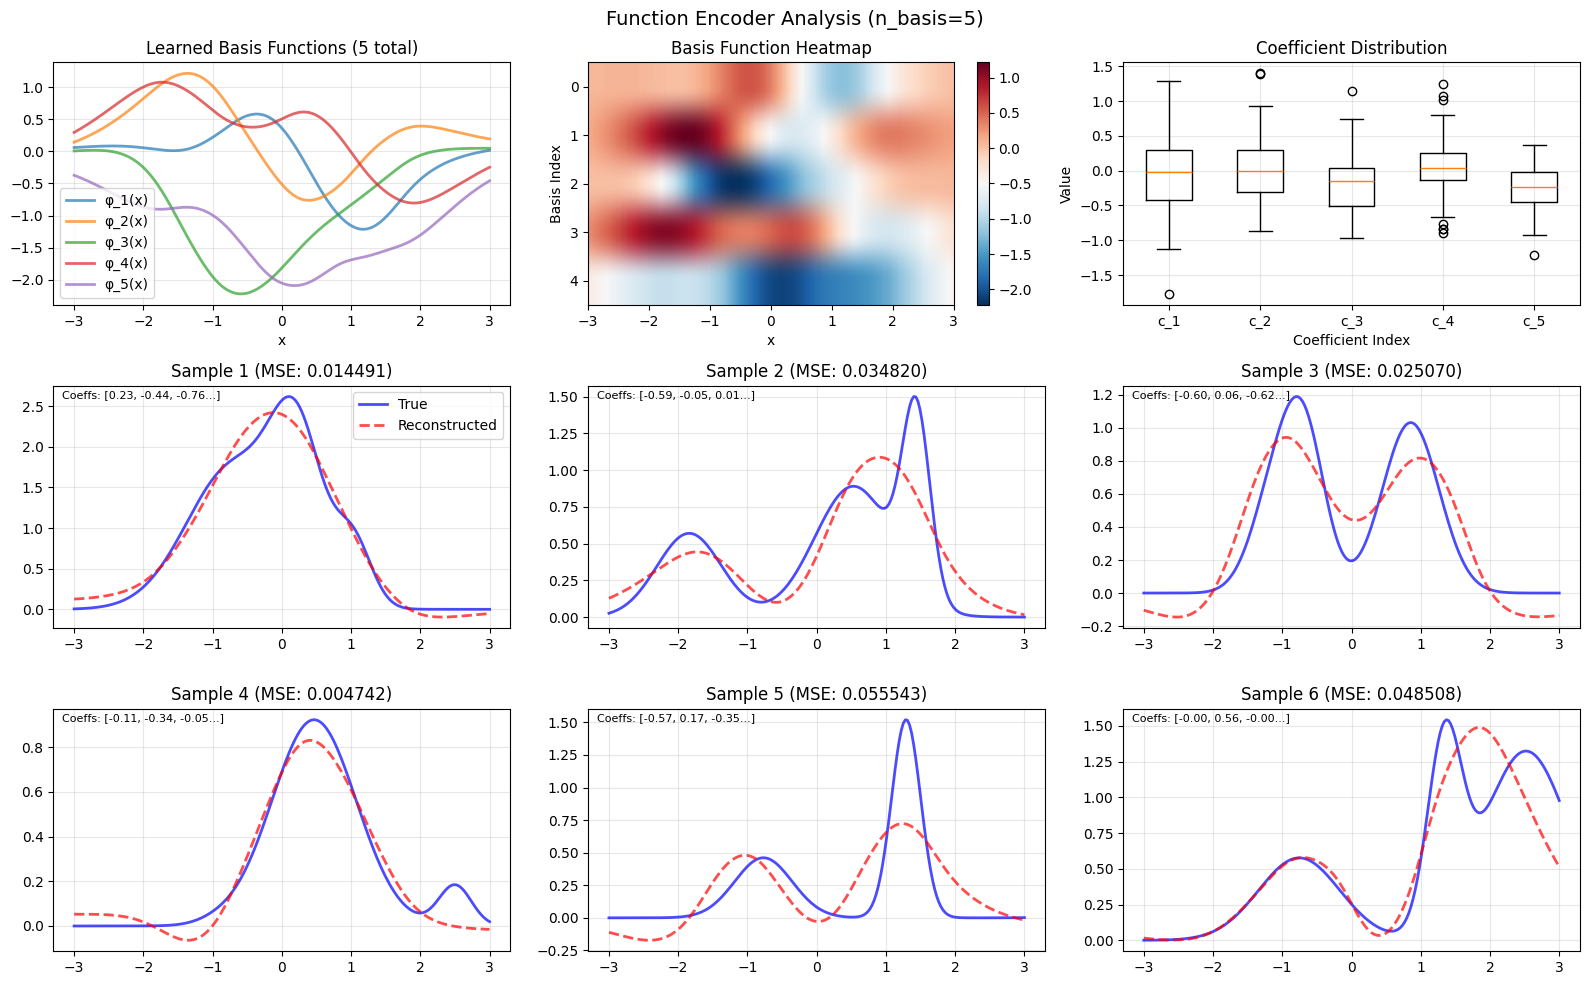


Statistics for 5 basis functions:
• Mean test MSE: 0.050105
• Std test MSE: 0.057591
• Parameters: 12,362

Analyzing model with 10 basis functions


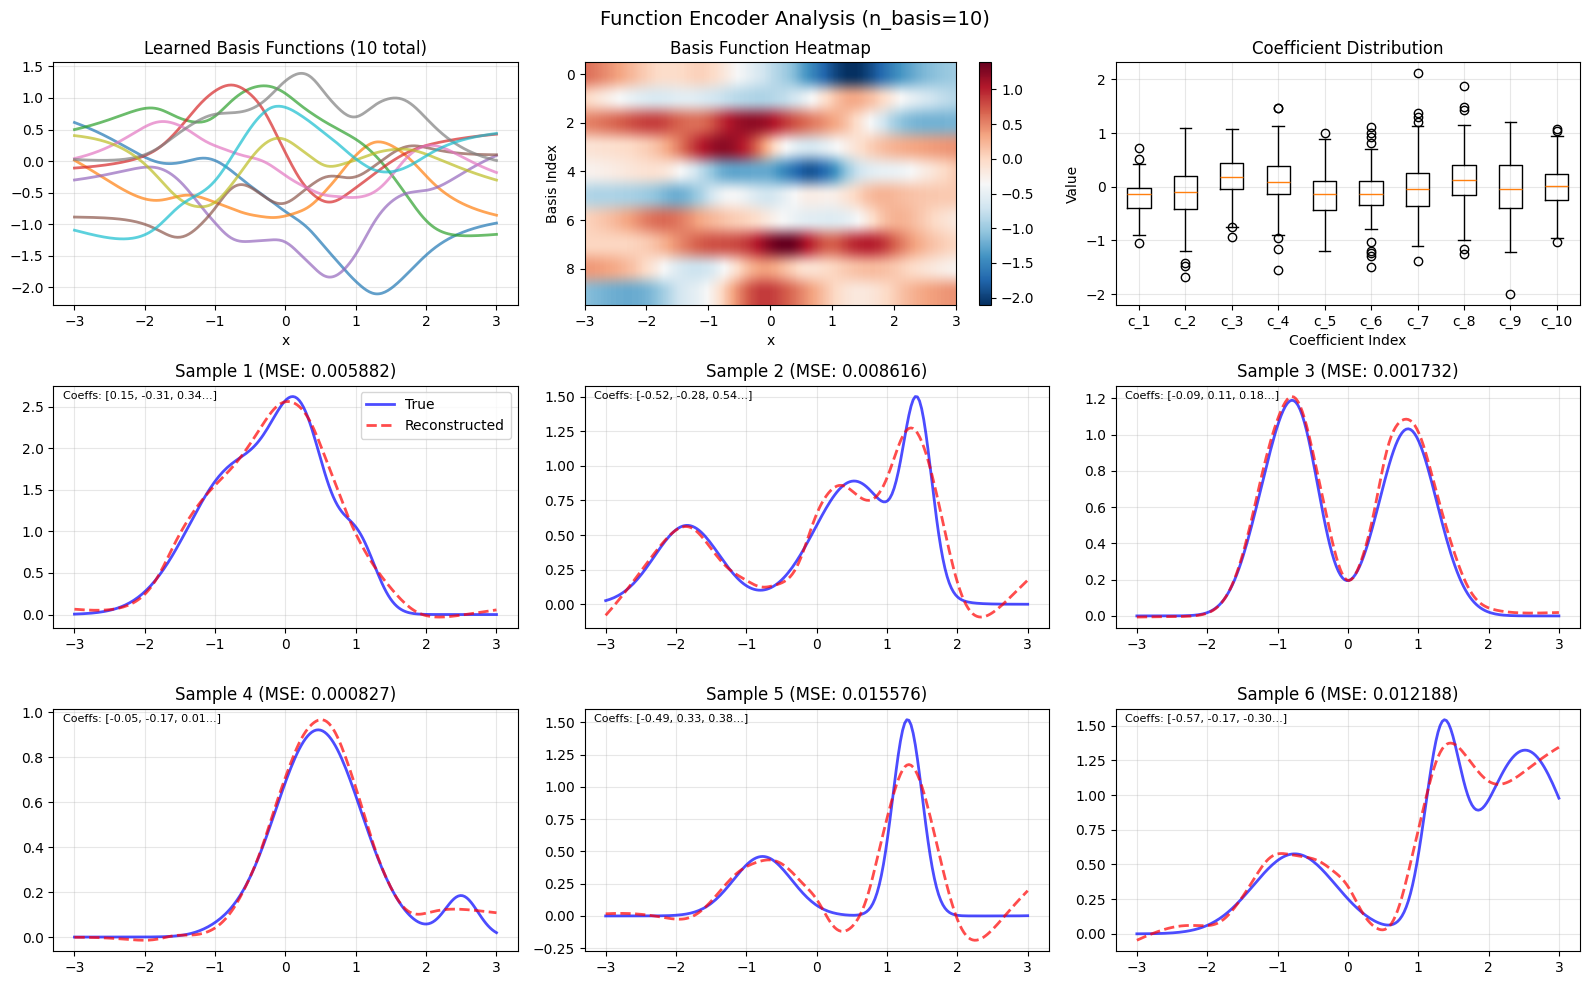


Statistics for 10 basis functions:
• Mean test MSE: 0.007118
• Std test MSE: 0.010347
• Parameters: 13,012

Analyzing model with 20 basis functions


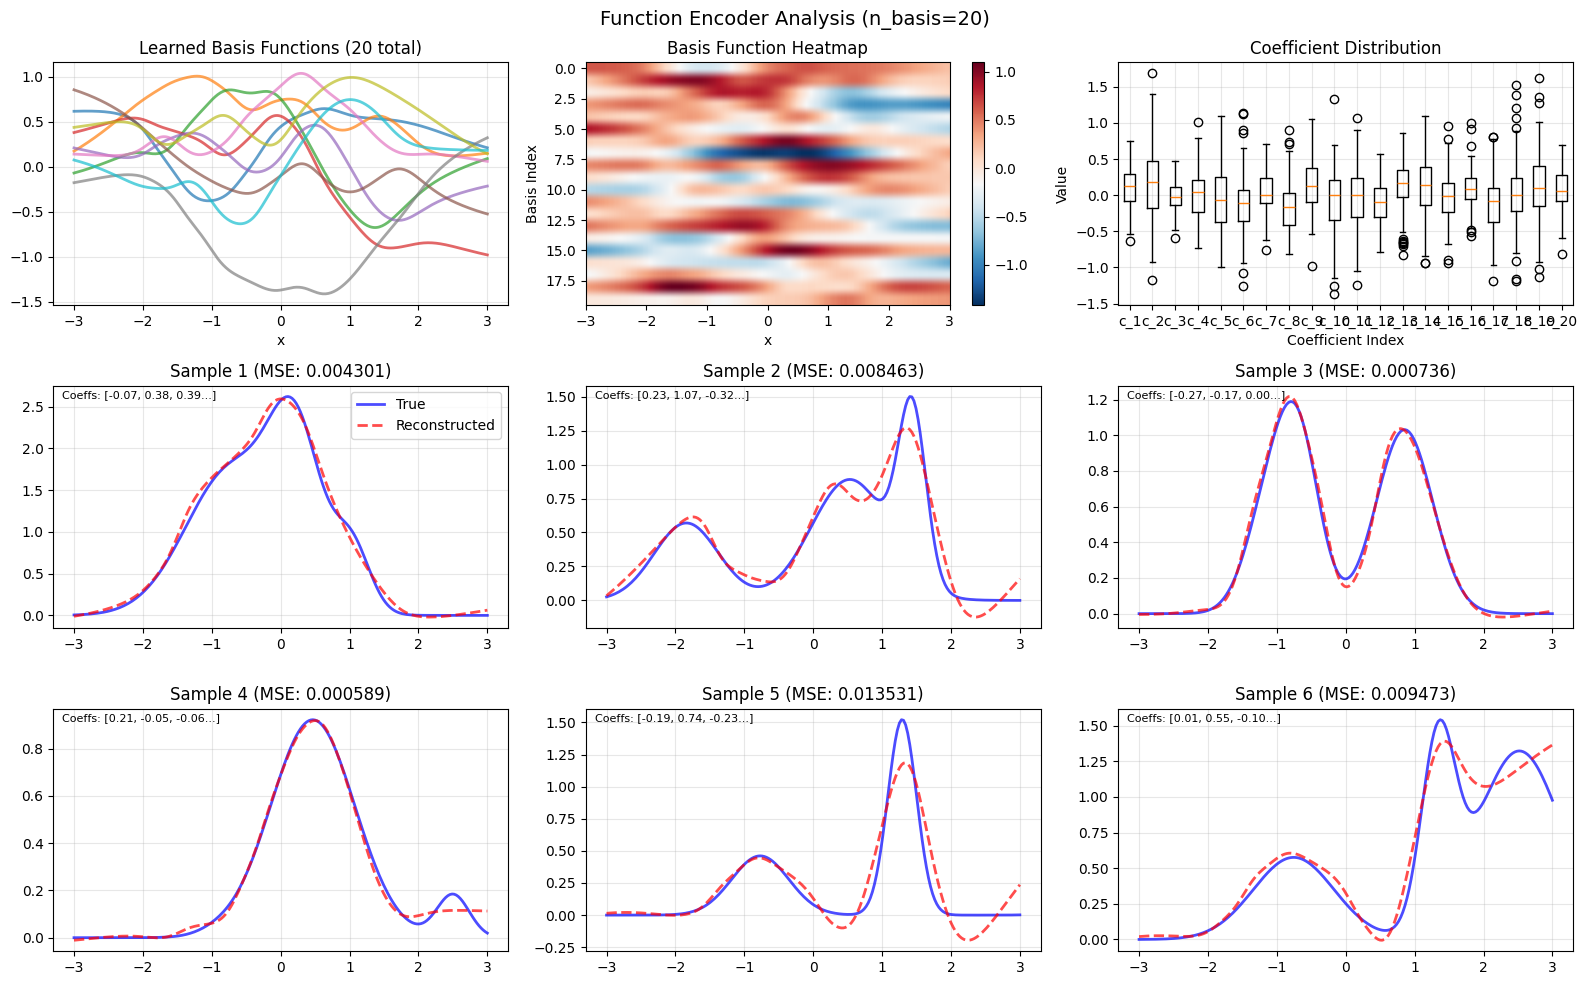


Statistics for 20 basis functions:
• Mean test MSE: 0.005167
• Std test MSE: 0.008654
• Parameters: 14,312


In [9]:
def analyze_learned_basis(model, dataset):
    """Analyze and visualize the learned basis functions and representations"""
    
    model.eval()
    
    # Extract basis functions
    x_dense = torch.linspace(-3, 3, 300).unsqueeze(-1).to(device)
    with torch.no_grad():
        basis_functions = model.decode_basis(x_dense).cpu().numpy()
    x_dense = x_dense.cpu().numpy().squeeze()
    
    fig = plt.figure(figsize=(16, 10))
    
    # Plot 1: Learned basis functions
    ax1 = plt.subplot(3, 3, 1)
    for i in range(min(model.n_basis, 10)):
        ax1.plot(x_dense, basis_functions[:, i], linewidth=2, alpha=0.7, 
                label=f'φ_{i+1}(x)')
    ax1.set_title(f'Learned Basis Functions ({model.n_basis} total)')
    ax1.set_xlabel('x')
    ax1.grid(True, alpha=0.3)
    if model.n_basis <= 5:
        ax1.legend()
    
    # Plot 2: Basis function heatmap
    ax2 = plt.subplot(3, 3, 2)
    im = ax2.imshow(basis_functions.T, aspect='auto', cmap='RdBu_r',
                   extent=[-3, 3, model.n_basis-0.5, -0.5])
    ax2.set_title('Basis Function Heatmap')
    ax2.set_xlabel('x')
    ax2.set_ylabel('Basis Index')
    plt.colorbar(im, ax=ax2)
    
    # Plot 3: Coefficient distribution
    ax3 = plt.subplot(3, 3, 3)
    coeffs_list = []
    with torch.no_grad():
        for i in range(100):
            sample = dataset[i]
            sensor_y = sample['sensor_y'].unsqueeze(0).to(device)
            coeffs = model.encode(sensor_y).cpu().numpy().squeeze()
            coeffs_list.append(coeffs)
    
    coeffs_array = np.array(coeffs_list)
    ax3.boxplot(coeffs_array, labels=[f'c_{i+1}' for i in range(model.n_basis)])
    ax3.set_title('Coefficient Distribution')
    ax3.set_xlabel('Coefficient Index')
    ax3.set_ylabel('Value')
    ax3.grid(True, alpha=0.3)
    
    # Plots 4-9: Reconstruction examples
    for idx in range(6):
        ax = plt.subplot(3, 3, idx + 4)
        
        sample = dataset[idx * 50]
        with torch.no_grad():
            sensor_y = sample['sensor_y'].unsqueeze(0).to(device)
            query_x = sample['query_x'].unsqueeze(0).to(device)
            
            # Get reconstruction
            pred_y = model(sensor_y, query_x).squeeze().cpu().numpy()
            
            # Get coefficients for this function
            coeffs = model.encode(sensor_y).squeeze().cpu().numpy()
        
        true_y = sample['query_y'].numpy()
        x = dataset.query_x.numpy()
        
        ax.plot(x, true_y, 'b-', linewidth=2, alpha=0.7, label='True')
        ax.plot(x, pred_y, 'r--', linewidth=2, alpha=0.7, label='Reconstructed')
        
        mse = np.mean((true_y - pred_y)**2)
        ax.set_title(f'Sample {idx+1} (MSE: {mse:.6f})')
        ax.grid(True, alpha=0.3)
        if idx == 0:
            ax.legend()
        
        # Add coefficient values as text
        coeff_str = ', '.join([f'{c:.2f}' for c in coeffs[:3]])
        if model.n_basis > 3:
            coeff_str += '...'
        ax.text(0.02, 0.98, f'Coeffs: [{coeff_str}]', 
               transform=ax.transAxes, fontsize=8, verticalalignment='top')
    
    plt.suptitle(f'Function Encoder Analysis (n_basis={model.n_basis})', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Compute statistics
    test_mses = []
    with torch.no_grad():
        for i in range(len(test_dataset)):
            sample = test_dataset[i]
            sensor_y = sample['sensor_y'].unsqueeze(0).to(device)
            query_x = sample['query_x'].unsqueeze(0).to(device)
            query_y = sample['query_y'].unsqueeze(0).to(device)
            
            pred_y = model(sensor_y, query_x)
            mse = F.mse_loss(pred_y, query_y).item()
            test_mses.append(mse)
    
    print(f"\nStatistics for {model.n_basis} basis functions:")
    print(f"• Mean test MSE: {np.mean(test_mses):.6f}")
    print(f"• Std test MSE: {np.std(test_mses):.6f}")
    print(f"• Parameters: {sum(p.numel() for p in model.parameters()):,}")


# Analyze each model
for n_basis in basis_sizes:
    print(f"\n{'='*60}")
    print(f"Analyzing model with {n_basis} basis functions")
    print('='*60)
    analyze_learned_basis(models[n_basis], dataset)

## Part 6: Comparing with Classical Approaches

In [ ]:
def compute_gram_matrix(basis_functions, x_range=(-3, 3), n_points=500):
    """
    Compute Gram matrix of basis functions.
    
    Args:
        basis_functions: Basis function values [n_points, n_basis]
        x_range: Integration domain
        n_points: Number of integration points
    
    Returns:
        gram_matrix: [n_basis, n_basis]
    """
    # Numerical integration using trapezoidal rule
    dx = (x_range[1] - x_range[0]) / n_points
    
    # Compute inner products
    gram = basis_functions.T @ basis_functions * dx
    
    return gram


def analyze_gram_matrix_with_regularization():
    """
    Analyze Gram matrices for different regularization settings.
    
    This function trains 4 different models:
    1. Original model (already trained without explicit L1)
    2. Model with L1_weight = 0.0 (no regularization)
    3. Model with L1_weight = 0.0001 (weak regularization)
    4. Model with L1_weight = 0.001 (stronger regularization)
    
    For each model, it shows:
    - Top row: The Gram matrix visualization
    - Bottom row: Diagonal values of the Gram matrix
    """
    
    # Train models with different L1 regularization during training
    print("="*70)
    print("GRAM MATRIX ANALYSIS: EFFECT OF L1 REGULARIZATION")
    print("="*70)
    print("\nTraining models with different L1 regularization strengths...")
    print("This will train 3 new models and compare with the original.")
    
    class RegularizedFunctionEncoder(nn.Module):
        """Function encoder with L1 regularization on decoder weights"""
        def __init__(self, sensor_dim, n_basis, hidden_dim=64, l1_weight=0.0):
            super().__init__()
            self.sensor_dim = sensor_dim
            self.n_basis = n_basis
            self.l1_weight = l1_weight
            
            # Encoder
            self.encoder = nn.Sequential(
                nn.Linear(sensor_dim, hidden_dim),
                nn.Tanh(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.Tanh(),
                nn.Linear(hidden_dim, n_basis)
            )
            
            # Decoder
            self.decoder = nn.Sequential(
                nn.Linear(1, hidden_dim),
                nn.Tanh(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.Tanh(),
                nn.Linear(hidden_dim, n_basis)
            )
        
        def encode(self, function_samples):
            return self.encoder(function_samples)
        
        def decode_basis(self, x):
            return self.decoder(x)
        
        def forward(self, function_samples, query_points):
            batch_size, n_points, _ = query_points.shape
            coefficients = self.encode(function_samples)
            basis_values = self.decoder(query_points.reshape(-1, 1))
            basis_values = basis_values.view(batch_size, n_points, self.n_basis)
            f_reconstructed = torch.einsum('bn,bpn->bp', coefficients, basis_values)
            return f_reconstructed
        
        def regularization_loss(self):
            """L1 regularization on decoder weights to promote orthogonality"""
            l1_loss = 0
            for param in self.decoder.parameters():
                l1_loss += torch.sum(torch.abs(param))
            return self.l1_weight * l1_loss
    
    # Train models with different L1 weights
    l1_weights = [0.0, 0.0001, 0.001]
    reg_models = {}
    
    for l1_weight in l1_weights:
        print(f"\nTraining model {len(reg_models)+1}/3 with L1 weight = {l1_weight}")
        model = RegularizedFunctionEncoder(
            sensor_dim=50, n_basis=10, l1_weight=l1_weight
        ).to(device)
        
        # Simplified training
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        
        model.train()
        for epoch in range(50):
            epoch_loss = 0
            for batch in train_loader:
                sensor_y = batch['sensor_y'].to(device)
                query_x = batch['query_x'].to(device)
                query_y = batch['query_y'].to(device)
                
                pred_y = model(sensor_y, query_x)
                loss = F.mse_loss(pred_y, query_y) + model.regularization_loss()
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
        
        reg_models[l1_weight] = model
        print(f"  Final loss: {epoch_loss/len(train_loader):.4f}")
    
    print("\n" + "="*60)
    print("VISUALIZING GRAM MATRICES")
    print("="*60)
    
    # Analyze Gram matrices
    fig, axes = plt.subplots(2, len(l1_weights) + 1, figsize=(18, 8))
    
    # Add original model without regularization
    models_to_analyze = [
        (0.0, models[10], "Original\n(No explicit L1)"),
        (0.0, reg_models[0.0], "L1 = 0.0\n(No regularization)"),
        (0.0001, reg_models[0.0001], "L1 = 0.0001\n(Weak regularization)"),
        (0.001, reg_models[0.001], "L1 = 0.001\n(Strong regularization)")
    ]
    
    gram_matrices = []
    orthogonality_scores = []
    
    for idx, (l1_weight, model, label) in enumerate(models_to_analyze):
        model.eval()
        
        # Get basis functions - ensure they're detached
        x_dense = torch.linspace(-3, 3, 500).unsqueeze(-1).to(device)
        with torch.no_grad():
            basis_functions = model.decode_basis(x_dense).detach().cpu().numpy()
        
        # Compute Gram matrix
        gram = compute_gram_matrix(basis_functions)
        gram_matrices.append(gram)
        
        # Compute orthogonality score (deviation from identity)
        n_basis = gram.shape[0]
        identity = np.eye(n_basis)
        ortho_score = np.linalg.norm(gram - identity, 'fro') / n_basis
        orthogonality_scores.append(ortho_score)
        
        # Plot Gram matrix
        ax = axes[0, idx]
        im = ax.imshow(gram, cmap='RdBu_r', vmin=-1, vmax=1)
        ax.set_title(f'{label}\nOrtho Score: {ortho_score:.3f}')
        ax.set_xlabel('Basis Index j')
        ax.set_ylabel('Basis Index i')
        plt.colorbar(im, ax=ax, fraction=0.046)
        
        # Add grid for clarity
        for i in range(n_basis):
            ax.axhline(i+0.5, color='gray', linewidth=0.5, alpha=0.3)
            ax.axvline(i+0.5, color='gray', linewidth=0.5, alpha=0.3)
        
        # Plot diagonal values (should be 1 for orthonormal)
        ax = axes[1, idx]
        diag_values = np.diag(gram)
        off_diag_values = gram[np.triu_indices(n_basis, k=1)]
        
        ax.bar(range(n_basis), diag_values, color='blue', alpha=0.7, label='Diagonal')
        ax.axhline(y=1.0, color='red', linestyle='--', linewidth=1, label='Target=1')
        ax.set_xlabel('Basis Index')
        ax.set_ylabel('Gram Matrix Diagonal')
        ax.set_title(f'Diagonal Values (mean={np.mean(diag_values):.3f})')
        ax.grid(True, alpha=0.3)
        if idx == 0:
            ax.legend()
        
        # Print statistics
        print(f"\n{label.replace(chr(10), ' ')} Statistics:")
        print(f"  Orthogonality score: {ortho_score:.4f}")
        print(f"  Diagonal mean: {np.mean(diag_values):.4f}")
        print(f"  Diagonal std: {np.std(diag_values):.4f}")
        print(f"  Off-diagonal mean: {np.mean(np.abs(off_diag_values)):.4f}")
        print(f"  Off-diagonal max: {np.max(np.abs(off_diag_values)):.4f}")
    
    plt.suptitle('Gram Matrix Analysis: Effect of L1 Regularization on Orthonormality\n' + 
                'Each column shows a different L1 regularization strength', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Compare reconstruction quality vs orthogonality
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Test reconstruction quality
    test_mses = []
    for l1_weight, model, label in models_to_analyze:
        model.eval()
        mses = []
        with torch.no_grad():
            for i in range(50):
                sample = test_dataset[i]
                sensor_y = sample['sensor_y'].unsqueeze(0).to(device)
                query_x = sample['query_x'].unsqueeze(0).to(device)
                query_y = sample['query_y'].unsqueeze(0).to(device)
                
                pred_y = model(sensor_y, query_x)
                mse = F.mse_loss(pred_y, query_y).item()
                mses.append(mse)
        test_mses.append(np.mean(mses))
    
    # Plot orthogonality vs reconstruction error
    ax1.scatter(orthogonality_scores, test_mses, s=100, alpha=0.7)
    for i, (_, _, label) in enumerate(models_to_analyze):
        ax1.annotate(label.replace('\n', ' '), (orthogonality_scores[i], test_mses[i]),
                    textcoords="offset points", xytext=(5,5), fontsize=9)
    ax1.set_xlabel('Orthogonality Score (lower is better)')
    ax1.set_ylabel('Test MSE')
    ax1.set_title('Orthogonality vs Reconstruction Quality')
    ax1.grid(True, alpha=0.3)
    
    # Plot basis function overlap heatmap
    ax2.bar(range(len(models_to_analyze)), orthogonality_scores, alpha=0.7)
    ax2.set_xticks(range(len(models_to_analyze)))
    ax2.set_xticklabels([label.replace('\n', ' ') for _, _, label in models_to_analyze], rotation=45)
    ax2.set_ylabel('Orthogonality Score')
    ax2.set_title('Orthogonality Comparison')
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*60)
    print("Summary:")
    print("- The 4 columns show 4 different models with varying L1 regularization")
    print("- Gram matrix diagonal values indicate basis normalization (should be 1)")
    print("- Off-diagonal values show orthogonality between basis functions (should be 0)")
    print("- L1 regularization can improve orthogonality but may affect reconstruction")
    print("- Trade-off exists between perfect orthogonality and representation power")

analyze_gram_matrix_with_regularization()

In [ ]:
def two_stage_training_with_orthogonality():
    """
    Two-stage training approach similar to DeepONet:
    Stage 1: Train decoder (basis functions) with L1 regularization
    Stage 2: Freeze decoder, train encoder only
    """
    
    print("="*70)
    print("TWO-STAGE TRAINING WITH ORTHOGONALITY CONSTRAINTS")
    print("="*70)
    
    # Create a fresh model for two-stage training
    class TwoStageFunctionEncoder(nn.Module):
        def __init__(self, sensor_dim, n_basis, hidden_dim=64, l1_weight=0.0):
            super().__init__()
            self.sensor_dim = sensor_dim
            self.n_basis = n_basis
            self.l1_weight = l1_weight
            
            # Encoder
            self.encoder = nn.Sequential(
                nn.Linear(sensor_dim, hidden_dim),
                nn.Tanh(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.Tanh(),
                nn.Linear(hidden_dim, n_basis)
            )
            
            # Decoder (will be trained first with L1)
            self.decoder = nn.Sequential(
                nn.Linear(1, hidden_dim),
                nn.Tanh(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.Tanh(),
                nn.Linear(hidden_dim, n_basis)
            )
        
        def encode(self, function_samples):
            return self.encoder(function_samples)
        
        def decode_basis(self, x):
            return self.decoder(x)
        
        def forward(self, function_samples, query_points):
            batch_size, n_points, _ = query_points.shape
            coefficients = self.encode(function_samples)
            basis_values = self.decoder(query_points.reshape(-1, 1))
            basis_values = basis_values.view(batch_size, n_points, self.n_basis)
            f_reconstructed = torch.einsum('bn,bpn->bp', coefficients, basis_values)
            return f_reconstructed
        
        def decoder_l1_regularization(self):
            """L1 regularization on decoder weights"""
            l1_loss = 0
            for param in self.decoder.parameters():
                l1_loss += torch.sum(torch.abs(param))
            return self.l1_weight * l1_loss
    
    # Hyperparameters
    n_basis = 20
    l1_weight = 1e-4
    
    print(f"\nHyperparameters:")
    print(f"  Number of basis functions: {n_basis}")
    print(f"  L1 regularization weight: {l1_weight}")
    
    # Create model
    model = TwoStageFunctionEncoder(
        sensor_dim=50, 
        n_basis=n_basis, 
        l1_weight=l1_weight
    ).to(device)
    
    # ========== STAGE 1: Train decoder with L1 regularization ==========
    print("\n" + "="*60)
    print("STAGE 1: Training Decoder (Basis Functions) with L1")
    print("="*60)
    
    # Stage 1 optimizer - only decoder parameters
    decoder_optimizer = optim.Adam(model.decoder.parameters(), lr=1e-3)
    encoder_optimizer = optim.Adam(model.encoder.parameters(), lr=1e-3)
    
    # Initialize encoder with small random weights for stage 1
    for param in model.encoder.parameters():
        param.data.uniform_(-0.01, 0.01)
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    
    stage1_losses = []
    n_epochs_stage1 = 100
    
    for epoch in tqdm(range(n_epochs_stage1), desc="Stage 1"):
        model.train()
        epoch_loss = 0
        
        for batch in train_loader:
            sensor_y = batch['sensor_y'].to(device)
            query_x = batch['query_x'].to(device)
            query_y = batch['query_y'].to(device)
            
            # Forward pass
            pred_y = model(sensor_y, query_x)
            
            # Reconstruction loss + L1 regularization on decoder
            loss = F.mse_loss(pred_y, query_y)
            l1_reg = model.decoder_l1_regularization()
            total_loss = loss + l1_reg
            
            # Update both encoder and decoder in stage 1
            decoder_optimizer.zero_grad()
            encoder_optimizer.zero_grad()
            total_loss.backward()
            decoder_optimizer.step()
            encoder_optimizer.step()
            
            epoch_loss += total_loss.item()
        
        stage1_losses.append(epoch_loss / len(train_loader))
        
        if (epoch + 1) % 20 == 0:
            print(f"  Epoch {epoch+1}: Loss = {stage1_losses[-1]:.6f}")
    
    print("\nStage 1 Complete - Freezing decoder")
    
    # Freeze decoder
    for param in model.decoder.parameters():
        param.requires_grad = False
    
    # ========== STAGE 2: Train encoder only ==========
    print("\n" + "="*60)
    print("STAGE 2: Training Encoder Only (Decoder Frozen)")
    print("="*60)
    
    # Stage 2 optimizer - only encoder parameters
    stage2_optimizer = optim.Adam(model.encoder.parameters(), lr=5e-4)
    
    stage2_losses = []
    n_epochs_stage2 = 100
    
    for epoch in tqdm(range(n_epochs_stage2), desc="Stage 2"):
        model.encoder.train()
        model.decoder.eval()
        epoch_loss = 0
        
        for batch in train_loader:
            sensor_y = batch['sensor_y'].to(device)
            query_x = batch['query_x'].to(device)
            query_y = batch['query_y'].to(device)
            
            # Forward pass
            pred_y = model(sensor_y, query_x)
            
            # Only reconstruction loss (no L1 in stage 2)
            loss = F.mse_loss(pred_y, query_y)
            
            # Update only encoder
            stage2_optimizer.zero_grad()
            loss.backward()
            stage2_optimizer.step()
            
            epoch_loss += loss.item()
        
        stage2_losses.append(epoch_loss / len(train_loader))
        
        if (epoch + 1) % 20 == 0:
            print(f"  Epoch {epoch+1}: Loss = {stage2_losses[-1]:.6f}")
    
    print("\nStage 2 Complete")
    
    # ========== Analyze learned basis functions ==========
    print("\n" + "="*60)
    print("ANALYZING LEARNED BASIS FUNCTIONS")
    print("="*60)
    
    # Extract basis functions
    x_dense = torch.linspace(-3, 3, 500).unsqueeze(-1).to(device)
    with torch.no_grad():
        basis_functions = model.decode_basis(x_dense).detach().cpu().numpy()
    x_dense_np = x_dense.cpu().numpy().squeeze()
    
    # Compute Gram matrices
    dx = (x_dense_np[1] - x_dense_np[0])
    
    # Regular Gram matrix
    gram_matrix = np.zeros((n_basis, n_basis))
    for i in range(n_basis):
        for j in range(i, n_basis):
            inner_product = np.sum(basis_functions[:, i] * basis_functions[:, j]) * dx
            gram_matrix[i, j] = inner_product
            if i != j:
                gram_matrix[j, i] = inner_product
    
    # Normalized Gram matrix (cosine similarity)
    norms = np.sqrt(np.diag(gram_matrix))
    normalized_gram = np.zeros((n_basis, n_basis))
    for i in range(n_basis):
        for j in range(n_basis):
            if norms[i] > 1e-9 and norms[j] > 1e-9:
                normalized_gram[i, j] = gram_matrix[i, j] / (norms[i] * norms[j])
            else:
                normalized_gram[i, j] = 0.0 if i != j else 1.0
    
    # ========== Plotting ==========
    fig = plt.figure(figsize=(20, 12))
    
    # Plot 1: Training curves
    ax1 = plt.subplot(3, 4, 1)
    ax1.plot(stage1_losses, 'b-', label='Stage 1 (with L1)', linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Stage 1 Training')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    ax2 = plt.subplot(3, 4, 2)
    ax2.plot(stage2_losses, 'r-', label='Stage 2 (encoder only)', linewidth=2)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_title('Stage 2 Training')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Plot 3: Basis functions
    ax3 = plt.subplot(3, 4, (3, 4))
    for i in range(min(n_basis, 20)):
        ax3.plot(x_dense_np, basis_functions[:, i], alpha=0.6, linewidth=1.5)
    ax3.set_title(f'Learned Basis Functions ({n_basis} total)')
    ax3.set_xlabel('x')
    ax3.set_ylabel('Basis value')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Regular Gram matrix
    ax4 = plt.subplot(3, 4, 5)
    im4 = ax4.imshow(gram_matrix, cmap='viridis', interpolation='nearest')
    ax4.set_title('Gram Matrix\n⟨φᵢ, φⱼ⟩')
    ax4.set_xlabel('Basis j')
    ax4.set_ylabel('Basis i')
    plt.colorbar(im4, ax=ax4, fraction=0.046)
    
    # Plot 5: Normalized Gram matrix
    ax5 = plt.subplot(3, 4, 6)
    im5 = ax5.imshow(normalized_gram, cmap='coolwarm', vmin=-1, vmax=1, interpolation='nearest')
    ax5.set_title('Normalized Gram Matrix\n(Cosine Similarity)')
    ax5.set_xlabel('Basis j')
    ax5.set_ylabel('Basis i')
    plt.colorbar(im5, ax=ax5, fraction=0.046)
    
    # Plot 6: Diagonal values of Gram matrix
    ax6 = plt.subplot(3, 4, 7)
    ax6.bar(range(n_basis), np.diag(gram_matrix), color='blue', alpha=0.7)
    ax6.axhline(y=1.0, color='red', linestyle='--', linewidth=1, label='Target (orthonormal)')
    ax6.set_title('Gram Matrix Diagonal\n(Basis Norms²)')
    ax6.set_xlabel('Basis index')
    ax6.set_ylabel('⟨φᵢ, φᵢ⟩')
    ax6.grid(True, alpha=0.3, axis='y')
    ax6.legend()
    
    # Plot 7: Off-diagonal distribution
    ax7 = plt.subplot(3, 4, 8)
    off_diag = gram_matrix[np.triu_indices(n_basis, k=1)]
    ax7.hist(off_diag, bins=30, color='green', alpha=0.7, edgecolor='black')
    ax7.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Target (orthogonal)')
    ax7.set_title('Off-Diagonal Distribution\n(Should be near 0)')
    ax7.set_xlabel('⟨φᵢ, φⱼ⟩ for i≠j')
    ax7.set_ylabel('Count')
    ax7.legend()
    ax7.grid(True, alpha=0.3)
    
    # Plot 8-11: Test reconstructions
    test_indices = [0, 50, 100, 150]
    for plot_idx, test_idx in enumerate(test_indices):
        ax = plt.subplot(3, 4, 9 + plot_idx)
        
        sample = test_dataset[test_idx]
        with torch.no_grad():
            sensor_y = sample['sensor_y'].unsqueeze(0).to(device)
            query_x = sample['query_x'].unsqueeze(0).to(device)
            
            # Get reconstruction and coefficients
            coeffs = model.encode(sensor_y).squeeze().cpu().numpy()
            pred_y = model(sensor_y, query_x).squeeze().cpu().numpy()
        
        true_y = sample['query_y'].numpy()
        x = dataset.query_x.numpy()
        
        ax.plot(x, true_y, 'k-', linewidth=2, alpha=0.7, label='True')
        ax.plot(x, pred_y, 'r--', linewidth=2, alpha=0.7, label='Reconstructed')
        
        mse = np.mean((true_y - pred_y)**2)
        ax.set_title(f'Test {plot_idx+1}\nMSE: {mse:.6f}')
        ax.grid(True, alpha=0.3)
        if plot_idx == 0:
            ax.legend()
        
        # Show sparsity of coefficients
        n_active = np.sum(np.abs(coeffs) > 0.01)
        ax.text(0.02, 0.98, f'Active: {n_active}/{n_basis}', 
               transform=ax.transAxes, fontsize=8, verticalalignment='top')
    
    plt.suptitle('Two-Stage Training with L1 Regularization for Orthogonal Basis', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Compute orthogonality metrics
    off_diagonal_sum = np.sum(np.abs(gram_matrix - np.diag(np.diag(gram_matrix))))
    diagonal_sum = np.sum(np.abs(np.diag(gram_matrix)))
    orthogonality_score = off_diagonal_sum / diagonal_sum if diagonal_sum > 1e-9 else float('inf')
    
    identity_deviation = np.sum(np.abs(normalized_gram - np.eye(n_basis)))
    
    print("\n" + "="*60)
    print("ORTHOGONALITY METRICS")
    print("="*60)
    print(f"Orthogonality Score (off-diag/diag): {orthogonality_score:.4f}")
    print(f"  - Lower is better (0 = perfectly orthogonal)")
    print(f"Deviation from Identity (normalized): {identity_deviation:.4f}")
    print(f"  - Lower is better (0 = perfectly orthonormal)")
    print(f"Mean diagonal value: {np.mean(np.diag(gram_matrix)):.4f}")
    print(f"Std diagonal value: {np.std(np.diag(gram_matrix)):.4f}")
    print(f"Mean |off-diagonal|: {np.mean(np.abs(off_diag)):.4f}")
    print(f"Max |off-diagonal|: {np.max(np.abs(off_diag)):.4f}")
    
    # Test performance
    model.eval()
    test_mses = []
    with torch.no_grad():
        for i in range(min(100, len(test_dataset))):
            sample = test_dataset[i]
            sensor_y = sample['sensor_y'].unsqueeze(0).to(device)
            query_x = sample['query_x'].unsqueeze(0).to(device)
            query_y = sample['query_y'].unsqueeze(0).to(device)
            
            pred_y = model(sensor_y, query_x)
            mse = F.mse_loss(pred_y, query_y).item()
            test_mses.append(mse)
    
    print(f"\nTest Performance:")
    print(f"  Mean MSE: {np.mean(test_mses):.6f}")
    print(f"  Std MSE: {np.std(test_mses):.6f}")
    
    return model, gram_matrix, normalized_gram

# Run the two-stage training
two_stage_model, gram, norm_gram = two_stage_training_with_orthogonality()

## Part 10: Two-Stage Training with L1 Regularization for Orthogonal Basis

Following the DeepONet approach, we'll train the function encoder in two stages:
1. **Stage 1**: Train decoder (basis functions) with L1 regularization to promote orthogonality
2. **Stage 2**: Freeze decoder, train only encoder to learn coefficients

This approach ensures clean, sparse basis functions.

In [ ]:
def l1_regularized_coefficients(f_values, basis_values, lambda_l1=0.1, max_iter=1000):
    """
    Compute coefficients with L1 regularization using proximal gradient descent.
    Solves: min_α ||f - Gα||² + λ||α||₁
    
    Args:
        f_values: Function values [n_points]
        basis_values: Basis functions [n_points, n_basis]
        lambda_l1: L1 regularization parameter
        max_iter: Maximum iterations for optimization
    
    Returns:
        coefficients: [n_basis]
    """
    G = basis_values
    f = f_values
    n_basis = G.shape[1]
    
    # Initialize coefficients
    alpha = torch.zeros(n_basis, device=G.device)
    
    # Compute Lipschitz constant for step size - handle MPS compatibility
    try:
        # Try using SVD-based norm computation (may fail on MPS)
        L = torch.linalg.norm(G.T @ G, 2).item()
    except:
        # Fallback: use power iteration to estimate largest eigenvalue
        GTG = G.T @ G
        v = torch.randn(n_basis, device=G.device)
        for _ in range(20):
            v = GTG @ v
            v = v / torch.norm(v)
        L = (v @ GTG @ v).item()
    
    step_size = 0.9 / L  # Slightly smaller step for stability
    
    def soft_threshold(x, threshold):
        """Soft thresholding operator for L1 proximal operator"""
        return torch.sign(x) * torch.maximum(torch.abs(x) - threshold, 
                                            torch.zeros_like(x))
    
    # Proximal gradient descent
    for _ in range(max_iter):
        # Gradient of squared loss
        grad = -2 * G.T @ (f - G @ alpha)
        
        # Gradient step
        alpha_temp = alpha - step_size * grad
        
        # Proximal step (soft thresholding)
        alpha = soft_threshold(alpha_temp, step_size * lambda_l1)
    
    return alpha


def test_l1_regularization():
    """Test L1 regularization effect on sparsity"""
    
    model = models[10].eval()
    
    # Different L1 regularization strengths
    lambda_values = [0.0, 0.01, 0.05, 0.1, 0.2]
    
    # Test function
    sample = dataset[100]
    x = dataset.query_x.numpy()
    y_true = sample['query_y'].numpy()
    
    fig, axes = plt.subplots(3, len(lambda_values), figsize=(20, 10))
    
    coeffs_all = []
    reconstructions = []
    sparsity_levels = []
    
    with torch.no_grad():
        sensor_y = sample['sensor_y'].to(device)
        query_x = sample['query_x'].unsqueeze(0).to(device)
        
        # Get basis functions
        sensor_x = dataset.sensor_x.unsqueeze(-1).to(device)
        basis_at_sensors = model.decode_basis(sensor_x).to(device)
        basis_at_query = model.decode_basis(query_x.squeeze()).to(device)
        
        for idx, lambda_l1 in enumerate(lambda_values):
            # Compute coefficients with L1 regularization
            if lambda_l1 == 0:
                # Use least squares for lambda=0
                coeffs = least_squares_coefficients(sensor_y, basis_at_sensors)
            else:
                coeffs = l1_regularized_coefficients(
                    sensor_y, basis_at_sensors, lambda_l1=lambda_l1
                )
            
            coeffs_all.append(coeffs)
            
            # Reconstruction
            y_pred = (coeffs @ basis_at_query.T).cpu().numpy()
            reconstructions.append(y_pred)
            
            # Count non-zero coefficients (threshold at 0.01)
            n_nonzero = torch.sum(torch.abs(coeffs) > 0.01).item()
            sparsity_levels.append(n_nonzero)
            
            # Plot 1: Reconstruction
            ax = axes[0, idx]
            ax.plot(x, y_true, 'k-', linewidth=2, alpha=0.7, label='True')
            ax.plot(x, y_pred, 'r--', linewidth=2, alpha=0.7, label='Reconstructed')
            mse = np.mean((y_true - y_pred)**2)
            ax.set_title(f'λ={lambda_l1}, MSE={mse:.4f}')
            ax.grid(True, alpha=0.3)
            if idx == 0:
                ax.set_ylabel('f(x)')
                ax.legend()
            
            # Plot 2: Coefficients
            ax = axes[1, idx]
            coeffs_np = coeffs.cpu().numpy()
            colors = ['red' if abs(c) > 0.01 else 'lightgray' 
                     for c in coeffs_np]
            ax.bar(range(len(coeffs_np)), coeffs_np, color=colors, alpha=0.7)
            ax.axhline(y=0, color='k', linewidth=0.5)
            ax.set_xlabel('Coefficient Index')
            ax.set_title(f'Non-zero: {n_nonzero}/{len(coeffs_np)}')
            ax.grid(True, alpha=0.3, axis='y')
            if idx == 0:
                ax.set_ylabel('Coefficient Value')
            
            # Plot 3: Active basis functions
            ax = axes[2, idx]
            x_dense = torch.linspace(-3, 3, 200).unsqueeze(-1).to(device)
            with torch.no_grad():
                basis_dense = model.decode_basis(x_dense).detach().cpu().numpy()
            
            # Plot only active basis functions
            for i, coeff in enumerate(coeffs_np):
                if abs(coeff) > 0.01:
                    ax.plot(x_dense.cpu().numpy(), 
                           basis_dense[:, i] * coeff, 
                           alpha=0.7, linewidth=2)
            
            ax.set_xlabel('x')
            ax.set_title(f'Active Basis Functions')
            ax.grid(True, alpha=0.3)
            if idx == 0:
                ax.set_ylabel('Weighted Basis')
    
    plt.suptitle('Effect of L1 Regularization on Sparsity', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Plot sparsity vs reconstruction error
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    mses = [np.mean((y_true - y_pred)**2) for y_pred in reconstructions]
    
    ax1.plot(lambda_values, sparsity_levels, 'bo-', linewidth=2, markersize=8)
    ax1.set_xlabel('L1 Regularization (λ)')
    ax1.set_ylabel('Number of Active Coefficients')
    ax1.set_title('Sparsity vs Regularization Strength')
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(sparsity_levels, mses, 'ro-', linewidth=2, markersize=8)
    for i, λ in enumerate(lambda_values):
        ax2.annotate(f'λ={λ}', (sparsity_levels[i], mses[i]), 
                    textcoords="offset points", xytext=(5,5), fontsize=8)
    ax2.set_xlabel('Number of Active Coefficients')
    ax2.set_ylabel('Reconstruction MSE')
    ax2.set_title('Reconstruction Error vs Sparsity')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("L1 Regularization Results:")
    for λ, n_active, mse in zip(lambda_values, sparsity_levels, mses):
        print(f"λ={λ:4.2f}: {n_active:2d} active coefficients, MSE={mse:.6f}")

test_l1_regularization()

## Part 9: L1 Regularization for Sparse Representations

L1 regularization promotes sparsity in the coefficient representation, helping identify the most important basis functions.

## Part 8: Least Squares Approach

The least squares approach solves for coefficients by minimizing the reconstruction error at sample points.

## Part 7: Monte Carlo Integration Approach

Instead of using neural networks for the encoder, we can directly compute coefficients using Monte Carlo integration when we have access to the learned basis functions.